# Dim 3 point 


In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-06 16:00:28.425755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-06 16:00:28.439865: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-06 16:00:28.444143: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup experiment

In [5]:
# We need one place to save all the experiment relevant info.  
experiment_config= {'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'mag_nabla_h_widened',
                                          'filter_scale', 
                                          'mag_nabla_u_widened',
                                          'uphp_rotated',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated',
                                          'vphp_rotated'],
                    
                    'coeff_channels'  : ['filter_scale','filter_scale','mag_nabla_h_widened', 'mag_nabla_u_widened'], 

                    'extra_channels'   : [],

                    'use_coeff_channels': True,

                    'all_time_range': slice(0, 800),
                    'train_time_range': slice(0, 640),
                    'test_time_range' : slice(-64, None),
                    'eval_time_range' : slice(-128, -64),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 

                    #'num_inputs': 55, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/'
                    
            }
experiment_config['num_inputs'] = len(experiment_config['input_channels']) * experiment_config['window_size']**2

## SimulationData Module
#### Load data for different simulations and prepare it with right variables and non-dims.

In this step all the variables and extra dimensions may be created that were not originally present. 
Each input and output variable gets its own containing variable (e.g. if top and bottom layer were two separate inputs, then in this step they may get separated out). 
Other examples might be that rotated variables, or magnitudes become their own variables in this step. 

In [6]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'], 
                             time_sel = experiment_config['all_time_range'],
                             single_layer_mask_flag=True
                             )

In [7]:
# have to add some of this information manually at the moment. 
experiment_config['num_inputs'] = 54 
networks = {'model1' : {'shape': [12,12,2]}, 
         'model2' : {'shape': [24,24,2]},
         'model3' : {'shape': [48,48,2]},
         'model4' : {'shape': [96,96,2]}, 
         'model5' : {'shape': [12,12,12,2]},
         'model6' : {'shape': [48,48,48,2]}, 
         'model7' : {'shape': [192,192,2]} 
           }
for model_key in networks.keys():
    networks[model_key]['save_dir'] = experiment_config['exp_ckpt_save_dir'] + model_key

In [11]:
# Load in and get the models ready to evaluate
for model_key in networks.keys():
    print(networks[model_key]['save_dir'])
    networks[model_key]['eval_sys'] = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 extra_channels=experiment_config['extra_channels'],
                                 use_norm_factors=True,
                                 eval_time_slice=experiment_config['eval_time_range'], 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=networks[model_key]['shape'], 
                                 ckpt_dir=networks[model_key]['save_dir'],
                                 use_coeff_channels=experiment_config['use_coeff_channels'])
    networks[model_key]['eval_sys'].read_ann_regression_model()
    networks[model_key]['eval_sys'].read_eval_data()
    networks[model_key]['eval_sys'].predict()

/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/model1
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/model2
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/model3
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/model4
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/model5
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/model6
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/model7


In [22]:
# Compute some metrics for each model 
for model_key in networks.keys():
    print(model_key)

    networks[model_key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', yh_region=slice(31, 50),descriptor='all', dims=['Time','xh','yh','zl'])
    networks[model_key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', yh_region=slice(31, 50), descriptor='all', dims=['Time','xh','yh','zl'])
    
    networks[model_key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', yh_region=slice(31, 50),descriptor='layer_wise', dims=['Time','xh','yh'])
    networks[model_key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', yh_region=slice(31, 50), descriptor='layer_wise', dims=['Time','xh','yh'])

    networks[model_key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'])
    networks[model_key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='time', dims=['Time'])

model1
model2
model3
model4
model5
model6
model7


In [23]:
for model_key in networks.keys():
    exp_name = 'DG'
    scale = '100'
    print('For model:'+ model_key +' with params: ' + str(networks[model_key]['eval_sys'].regress_sys.network.count_parameters()))
    print(exp_name+' '+scale+'km is '+ str(networks[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values))
    

For model:model1 with params: 842
DG 100km is 0.875496399490071
For model:model2 with params: 1970
DG 100km is 0.90972976131481
For model:model3 with params: 5090
DG 100km is 0.9360078485843628
For model:model4 with params: 14786
DG 100km is 0.9460483509921142
For model:model5 with params: 998
DG 100km is 0.8825899133790379
For model:model6 with params: 7442
DG 100km is 0.934769179432397
For model:model7 with params: 48002
DG 100km is 0.9568182074802263


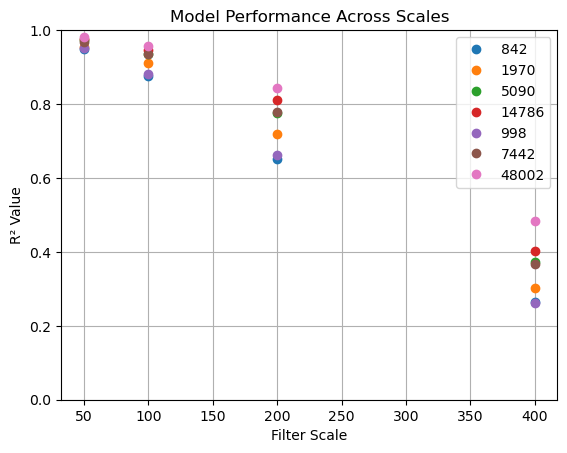

In [37]:
import matplotlib.pyplot as plt

# Define a color map for model_keys
color_map = {key: color for key, color in zip(networks.keys(), plt.cm.tab10.colors)}

for model_key in networks.keys():
    flag = 0
    exp_name = 'DG'
    for scale in experiment_config['filter_scales']:
        R2_value = networks[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values
        num_params = networks[model_key]['eval_sys'].regress_sys.network.count_parameters()
        
        # Use the same color for each model_key
        color = color_map[model_key]

        if flag == 0:
            plt.plot(int(scale), R2_value, 'o', label=str(num_params), color=color)
            flag = 1
        else:
            plt.plot(int(scale), R2_value, 'o', color=color)

plt.legend()
plt.xlabel("Filter Scale")
plt.ylabel("R² Value")
plt.ylim([0,1])
plt.grid()
plt.title("Model Performance Across Scales")
plt.show()


In [21]:
for model_key in networks.keys():
    exp_name = 'DG'
    scale = '100'
    print('For model:'+ model_key +' with params: ' + str(networks[model_key]['eval_sys'].regress_sys.network.count_parameters()))
    print(exp_name+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(networks[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_layer_wise.values))
    print(exp_name+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(networks[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_R2_layer_wise.values))

For model:model1 with params: 842
DG 100km, R2 for uphp is (layer:[0,1])[0.88966086 0.84039177]
DG 100km, R2 for vphp is (layer:[0,1])[0.95449443 0.90797322]
For model:model2 with params: 1970
DG 100km, R2 for uphp is (layer:[0,1])[0.91494995 0.8967679 ]
DG 100km, R2 for vphp is (layer:[0,1])[0.9649389  0.92454119]
For model:model3 with params: 5090
DG 100km, R2 for uphp is (layer:[0,1])[0.94256727 0.91974777]
DG 100km, R2 for vphp is (layer:[0,1])[0.97220752 0.9403559 ]
For model:model4 with params: 14786
DG 100km, R2 for uphp is (layer:[0,1])[0.95298078 0.92887115]
DG 100km, R2 for vphp is (layer:[0,1])[0.97832002 0.94823637]
For model:model5 with params: 998
DG 100km, R2 for uphp is (layer:[0,1])[0.89502594 0.85176452]
DG 100km, R2 for vphp is (layer:[0,1])[0.95448104 0.89637297]
For model:model6 with params: 7442
DG 100km, R2 for uphp is (layer:[0,1])[0.94227179 0.91617542]
DG 100km, R2 for vphp is (layer:[0,1])[0.97434138 0.94641504]
For model:model7 with params: 48002
DG 100km, R

## MLXarrayDataset 

Go from simulation data to batchesm but still as Xarray objects. 
In this step things like dropping extra points, masking of data etc happen. 

In [7]:
ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'])

Will load : 1.807872 gb into memory.
load took: 37.7767 seconds


In [8]:
ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      num_batches = experiment_config['num_test_batches'])

Will load : 0.1807872 gb into memory.
load took: 6.1450 seconds


## MLJAXDataset 

### Convert these xbatcher batches to processed ones for training

This needs to take care of extra dims, like Xn,Yn.

In [9]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      use_coeff_channels=experiment_config['use_coeff_channels'],
                                      do_normalize=True)

In [10]:
test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      use_coeff_channels=experiment_config['use_coeff_channels'],
                                      do_normalize=True)

In [11]:
ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [12]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Input (Xp) batch shape:", batch_out['Xp'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (53692, 54)
Input (Xp) batch shape: (53692, 1)
Output (y) batch shape: (53692, 2)


## AnnRegressionSystem (and associated NN setup modules ArtificialNeuralNetwork and PointwiseANN).


In [13]:
num_in = batch_out['X'].shape[-1]
experiment_config['num_inputs'] = num_in
experiment_config['num_inputs']

54

In [14]:
networks = {'model1' : {'shape': [12,12,2]}, 
         'model2' : {'shape': [24,24,2]},
         'model3' : {'shape': [48,48,2]},
         'model4' : {'shape': [96,96,2]}, 
         'model5' : {'shape': [12,12,12,2]},
         'model6' : {'shape': [48,48,48,2]}, 
         'model7' : {'shape': [192,192,2]} 
           }

In [15]:
for model_key in networks.keys():
    
    ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                    shape = networks[model_key]['shape']) 
    networks[model_key]['num_params'] = ANN_model.count_parameters()
    regress_sys = ML_classes.AnnRegressionSystem(ANN_model, loss_type='mae')

    print('Start training: ', model_key)
    regress_sys.train_system(ML_data_combo, num_epoch=501, print_freq=20, min_relative_improvement=1e-2)
    
    networks[model_key]['regress_sys'] = regress_sys

    networks[model_key]['save_dir'] = experiment_config['exp_ckpt_save_dir'] + model_key

    regress_sys.save_checkpoint(networks[model_key]['save_dir'])

Start training:  model1
At epoch 1. Train loss :  1.600465201042794 , Test loss: 1.2644960641860963 , Test R2: 0.297421395778656
At epoch 21. Train loss :  0.8502581747802528 , Test loss: 0.9468571186065674 , Test R2: 0.5734915614128113
Early stopping at epoch 39. No improvement in 10 epochs.
Restored best model with smoothed test loss 0.939487
Start training:  model2
At epoch 1. Train loss :  1.397169296805923 , Test loss: 1.2081396102905273 , Test R2: 0.34035823345184324
At epoch 21. Train loss :  0.7895162492185026 , Test loss: 0.8822675943374634 , Test R2: 0.6150591015815735
At epoch 41. Train loss :  0.7677706463916881 , Test loss: 0.8576512694358825 , Test R2: 0.6358007788658142
Early stopping at epoch 46. No improvement in 10 epochs.
Restored best model with smoothed test loss 0.863037
Start training:  model3
At epoch 1. Train loss :  1.3237539626456596 , Test loss: 1.1876999139785767 , Test R2: 0.36242631673812864
At epoch 21. Train loss :  0.7499441440041 , Test loss: 0.835406

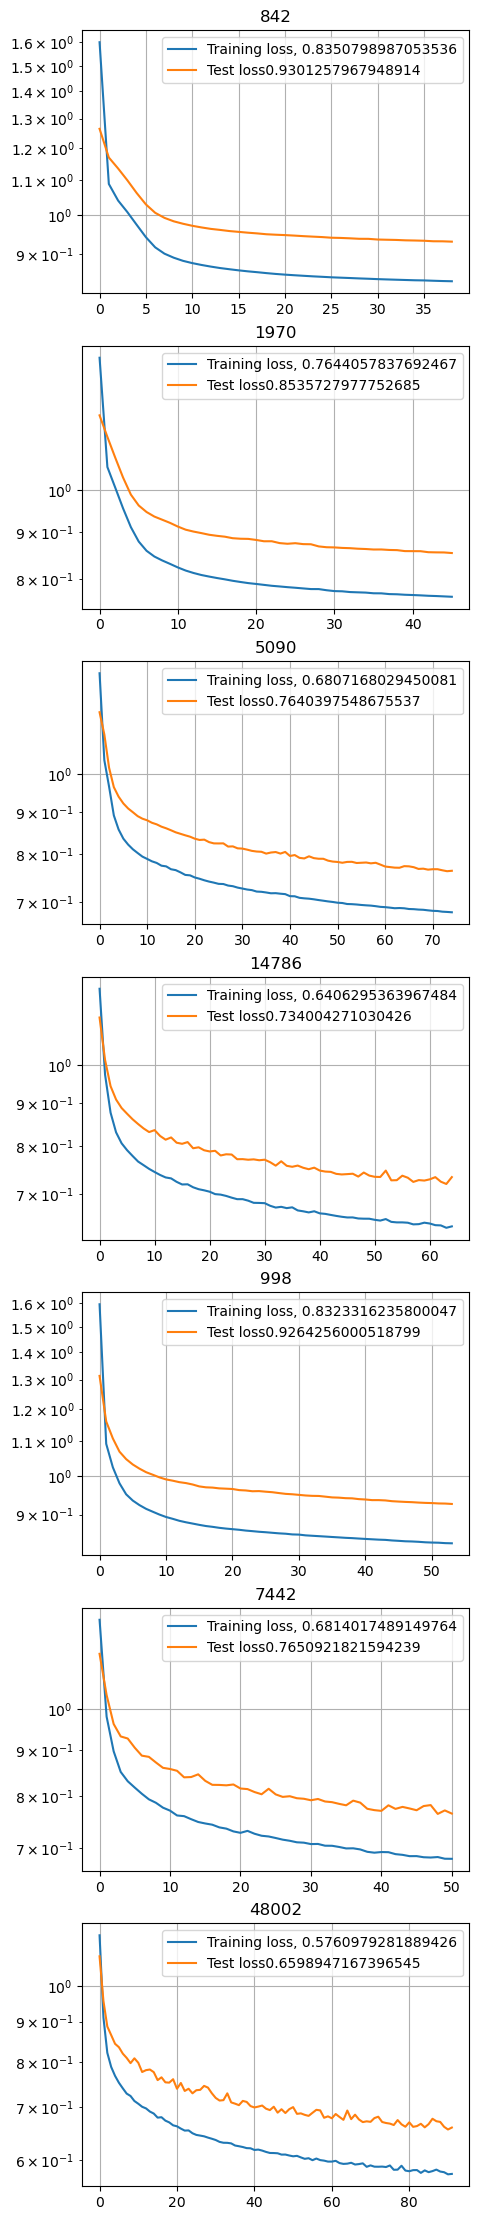

In [18]:
## Loss plot
num_models = len(networks.keys())

fig = plt.figure(figsize=(5, 4*num_models))  

for i, model_key in enumerate(networks.keys()):
    regress_sys = networks[model_key]['regress_sys'] 
    plt.subplot(num_models, 1, i+1)
    plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
    plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

    plt.grid()
    plt.yscale('log')
    plt.title(networks[model_key]['regress_sys'].network.count_parameters())
    plt.legend()

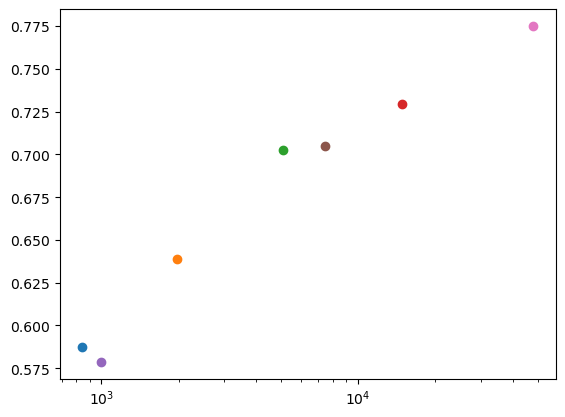

In [21]:
for model_key in networks.keys():
    plt.plot(networks[model_key]['num_params'], 
             networks[model_key]['regress_sys'].test_R2[-1], 'o')
plt.xscale('log')


## Evaluation Module

In [22]:
for model_key in networks.keys():
    print(networks[model_key]['save_dir'])
    networks[model_key]['eval_sys'] = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 extra_channels=experiment_config['extra_channels'],
                                 use_norm_factors=True,
                                 eval_time_slice=experiment_config['eval_time_range'], 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=networks[model_key]['shape'], 
                                 ckpt_dir=networks[model_key]['save_dir'],
                                 use_coeff_channels=experiment_config['use_coeff_channels'])
    networks[model_key]['eval_sys'].read_ann_regression_model()
    networks[model_key]['eval_sys'].read_eval_data()
    networks[model_key]['eval_sys'].predict()

    networks[model_key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', yh_region=slice(31, 50),descriptor='layer_wise', dims=['Time','xh','yh'])
    networks[model_key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', yh_region=slice(31, 50), descriptor='layer_wise', dims=['Time','xh','yh'])


    networks[model_key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'])
    networks[model_key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='time', dims=['Time'])

/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/model1
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/model2
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/model3
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/model4
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/model5
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/model6
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_model_sizes/window_3/model7


In [ ]:

    for exp in experiment_config['simulation_names']: 
    #for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_rotated_R2_layer_wise.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_rotated_R2_layer_wise.values))

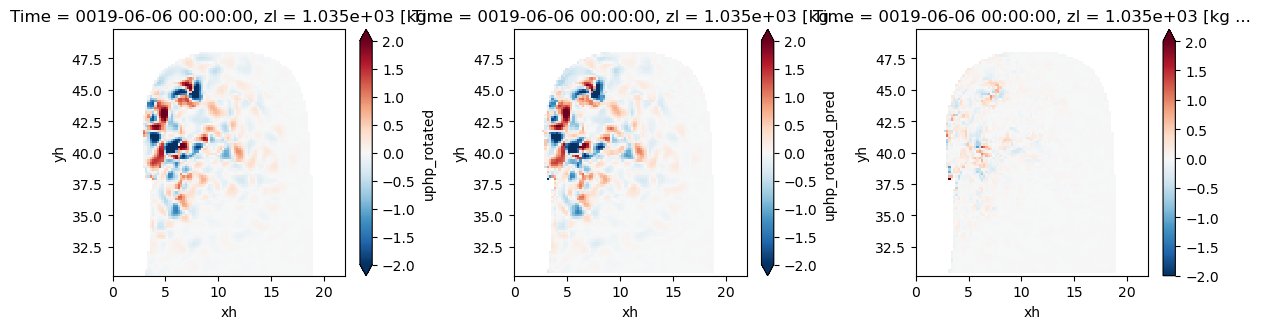

In [49]:
plt.figure(figsize=(12, 3.4))
exp_name = experiment_config['simulation_names'][0]
zl = 0
vmin = -2

plt.subplot(131)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(132)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl).plot(vmin=vmin)

plt.tight_layout()

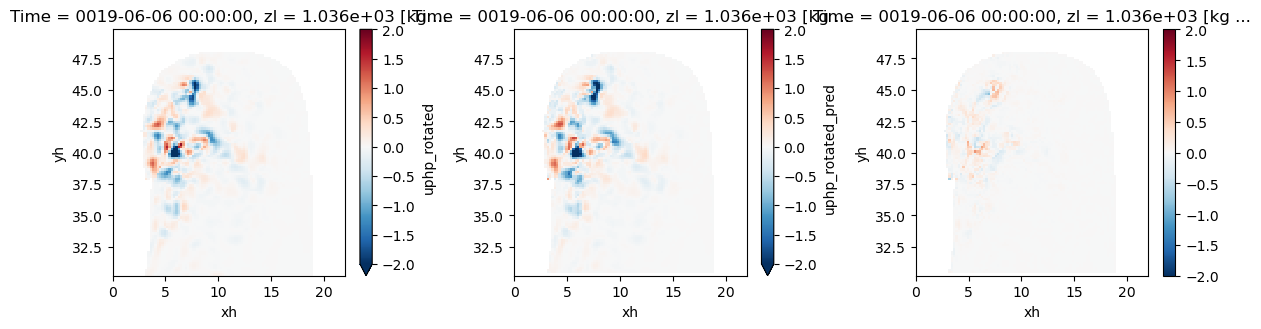

In [50]:
plt.figure(figsize=(12, 3.4))
exp_name = experiment_config['simulation_names'][0]
zl = 1
vmin = -2

plt.subplot(131)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(132)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl).plot(vmin=vmin)

plt.tight_layout()

In [51]:
test_eval.calc_time_hor_space_metrics(var='uphp_rotated', yh_region=slice(31, 50),descriptor='layer_wise', dims=['Time','xh','yh'])
test_eval.calc_time_hor_space_metrics(var='vphp_rotated', yh_region=slice(31, 50), descriptor='layer_wise', dims=['Time','xh','yh'])


test_eval.calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'])
test_eval.calc_time_hor_space_metrics(var='vphp_rotated', descriptor='time', dims=['Time'])

In [52]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_rotated_R2_layer_wise.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_rotated_R2_layer_wise.values))

DG 50km, R2 for uphp is (layer:[0,1])[0.96899471 0.96783904]
DG 50km, R2 for vphp is (layer:[0,1])[0.98871163 0.97971419]
DG 100km, R2 for uphp is (layer:[0,1])[0.93845672 0.91732043]
DG 100km, R2 for vphp is (layer:[0,1])[0.97573846 0.94922918]
DG 200km, R2 for uphp is (layer:[0,1])[0.80960226 0.68319001]
DG 200km, R2 for vphp is (layer:[0,1])[0.9018091  0.81174887]
DG 400km, R2 for uphp is (layer:[0,1])[0.46186233 0.11655539]
DG 400km, R2 for vphp is (layer:[0,1])[0.79882034 0.34176989]


<Figure size 1200x550 with 0 Axes>

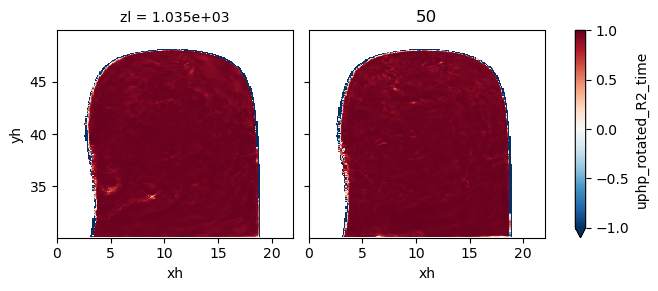

<Figure size 1200x550 with 0 Axes>

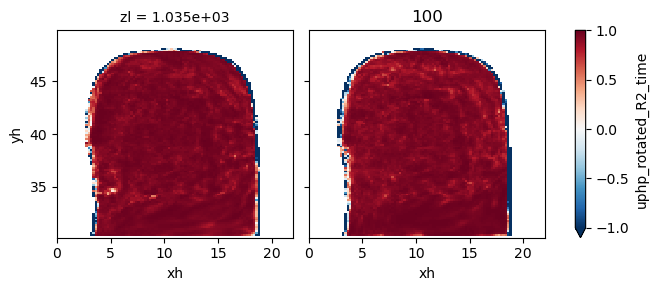

<Figure size 1200x550 with 0 Axes>

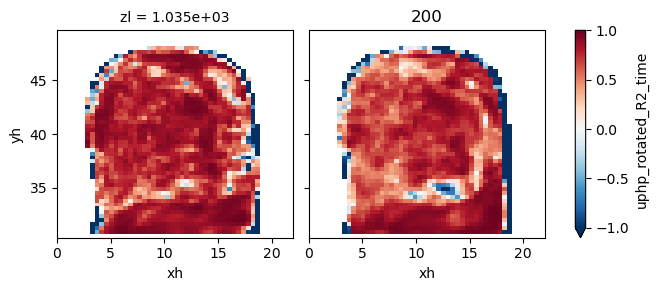

<Figure size 1200x550 with 0 Axes>

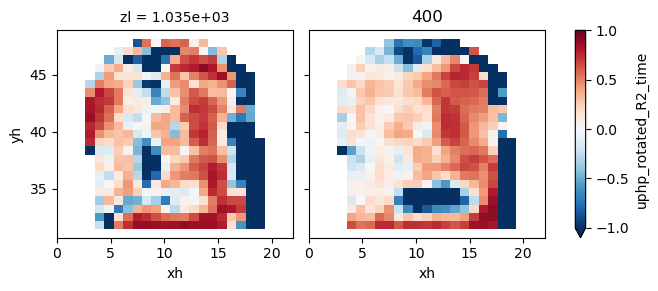

In [53]:
for scale in experiment_config['filter_scales']:

    plt.figure(figsize=(12, 5.5))

    test_eval.eval_datatree.ml_dataset[exp][scale].uphp_rotated_R2_time.plot(col='zl', vmax=1)
    plt.title(scale)

<Figure size 1200x550 with 0 Axes>

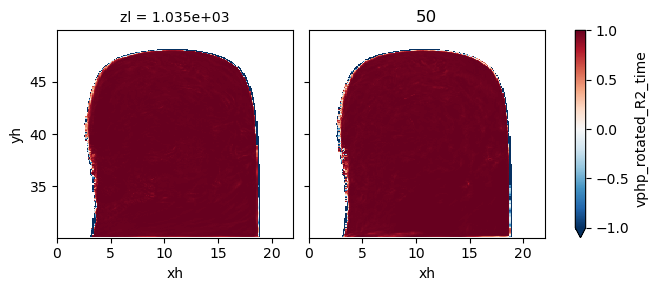

<Figure size 1200x550 with 0 Axes>

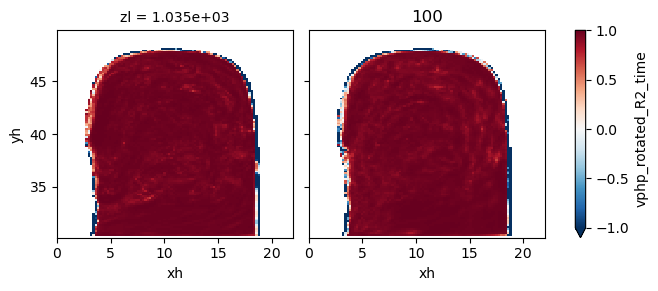

<Figure size 1200x550 with 0 Axes>

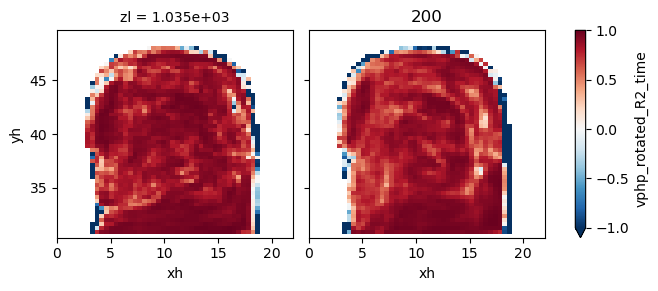

<Figure size 1200x550 with 0 Axes>

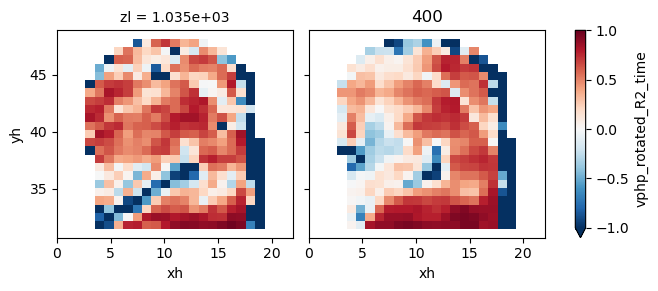

In [54]:
for scale in experiment_config['filter_scales']:

    plt.figure(figsize=(12, 5.5))

    test_eval.eval_datatree.ml_dataset[exp][scale].vphp_rotated_R2_time.plot(col='zl', vmax=1)
    plt.title(scale)